# Conformalized Early Stopping -- Regression

- We implement the conformalized early stopping algorithm as well as the benchmark methods on the Medical Expenditure Panel Survey data (MEPS) collected from the year 2021. The Medical Expenditure Panel Survey (MEPS) data consists of large scale surveys of families, individuals, and medical providers and collects data on cost and usage of medical services and demographics. 

- We follow the data cleaning process and used the same model architecture as in the conformalized quantile regression experiments https://github.com/yromano/cqr/tree/master/get_meps_data and download the dataset from https://github.com/IBM/AIF360. 

- For the benchmark methods, we randomly selected 2000 samples for training the deep neural network models, 1000 validation samples to decide the early stopped models, and additional 1000 samples for calibration. For the conformalized early stopping method, we use the same subset of selected samples but merge the training and validation samples and use the merged dataset for training. The 1000 calibration samples are used together with new test point to select the best models. For both benchmark and our proposed method, we train the model for  𝑇max=200  epochs, saving every snapshot, and compute the marginal coverage rate and size of the prediction intervals averaged over 100 test samples.

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import torch as th
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sympy import *
import pathlib
import pdb
import matplotlib.pyplot as plt

from method import CES_regression
from networks import mse_model, MSE_loss
from inference import Conformal_PI

In [14]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

## Loading and cleaning the dataset

In [15]:
reload_dataset = True

In [16]:
if reload_dataset:
  !git clone https://github.com/yromano/cqr.git

Cloning into 'cqr'...
remote: Enumerating objects: 1152, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1152 (delta 0), reused 1 (delta 0), pack-reused 1148
Receiving objects: 100% (1152/1152), 5.14 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (728/728), done.


In [17]:
# load the dataset
if reload_dataset:
  !Rscript cqr/get_meps_data/download_data.R


By using this script you acknowledge the responsibility for reading and
abiding by any copyright/usage rules and restrictions as stated on the
MEPS web site (https://meps.ahrq.gov/data_stats/data_use.jsp).

Continue [y/n]? > y
Loading required package: foreign
trying URL 'https://meps.ahrq.gov/mepsweb/data_files/pufs/h181ssp.zip'
Content type 'application/zip' length 13303652 bytes (12.7 MB)
downloaded 12.7 MB

Loading dataframe from file: h181.ssp
Exporting dataframe to file: h181.csv
trying URL 'https://meps.ahrq.gov/mepsweb/data_files/pufs/h192ssp.zip'
Content type 'application/zip' length 15505898 bytes (14.8 MB)
downloaded 14.8 MB

Loading dataframe from file: h192.ssp
Exporting dataframe to file: h192.csv


In [18]:
# clean the dataset 
if reload_dataset:
  !python cqr/get_meps_data/main_clean_and_save_to_csv.py

Cleaning and saving MEPS 19, 20 and 21
writing file: meps_19_reg.csv
writing file: meps_20_reg.csv
writing file: meps_21_reg.csv
Done.
Loading processed data and printing the dimensions
MEPS 19: n = 15785 p = 139 response len = 15785
MEPS 20: n = 17541 p = 139 response len = 17541
MEPS 21: n = 15656 p = 139 response len = 15656


In [19]:
from cqr.datasets import datasets

class PrepareData(Dataset):

    def __init__(self, X, y, scale_X=False):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()


## Training and evaluating the benchmark methods

In [28]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

np.random.seed(666)
idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set
idx_train_BM, idx_val_BM, idx_cal_BM = idx[:n_train], idx[n_train:n_val+n_train], idx[n_val+n_train: n_val+n_train + n_cal]

# load the data
X, y = datasets.GetDataset('meps_21', '')

# split the dataset into disjoint subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_BM])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# scale the response values by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_BM]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_BM, y_train_BM = X_train[idx_train_BM], y_train[idx_train_BM]
X_val_BM, y_val_BM = X_train[idx_val_BM], y_train[idx_val_BM]
X_cal_BM, y_cal_BM = X_train[idx_cal_BM], y_train[idx_cal_BM]

print("Size (BM): train (%d, %d), validation (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM.shape[0], X_train_BM.shape[1], X_val_BM.shape[0], X_val_BM.shape[1], 
       X_cal_BM.shape[0], X_cal_BM.shape[1], X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (BM): train (2000, 139), validation (1000, 139), calibration (1000, 139), test (100, 139)


In [30]:
# set model hyperparameter
input_size = X_train_BM.shape[1]
hidden_layer_size = 64
batch_size = 64
num_epochs = 200
learning_rate = 0.001
wd = 0.01

num_workers = 0

seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

In [31]:
train_loader = DataLoader(PrepareData(X_train_BM, y_train_BM, scale_X=False), batch_size=batch_size)
val_loader = DataLoader(PrepareData(X_val_BM, y_val_BM, scale_X=False), batch_size=batch_size, drop_last = True) 
calib_loader = DataLoader(PrepareData(X_cal_BM, y_cal_BM, scale_X=False), batch_size=1, shuffle = False, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), validation (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(val_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (32), validation (15), calibration (1000), test (100)


In [32]:
# intialize the model
mod = mse_model(in_shape = input_size, hidden_size = hidden_layer_size)
optimizer = torch.optim.Adam(mod.parameters(), lr=learning_rate, weight_decay = wd)
if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=learning_rate, val_loader=val_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.001


In [33]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
BM_reg.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 9% 	 train_loss: 7.73  took: 0.08s
Epoch 1 of 200, 18% 	 train_loss: 6.85  took: 0.01s
Epoch 1 of 200, 28% 	 train_loss: 8.29  took: 0.01s
Epoch 1 of 200, 37% 	 train_loss: 27.05  took: 0.01s
Epoch 1 of 200, 46% 	 train_loss: 15.36  took: 0.01s
Epoch 1 of 200, 56% 	 train_loss: 19.48  took: 0.01s
Epoch 1 of 200, 65% 	 train_loss: 3.39  took: 0.01s
Epoch 1 of 200, 75% 	 train_loss: 14.03  took: 0.01s
Epoch 1 of 200, 84% 	 train_loss: 2.12  took: 0.01s
Epoch 1 of 200, 93% 	 train_loss: 15.72  took: 0.01s
val_loss = 7.24
Snapshot saved at epoch 1.
Epoch 2 of 200, 9% 	 train_loss: 4.60  took: 0.01s
Epoch 2 of 200, 18% 	 train_loss: 5.19  took: 0.01s
Epoch 2 of 200, 28% 	 train_loss: 6.42  took: 0.01s
Epoch 2 of 200, 37% 	 train_loss: 21.32  took: 0.01s
Epoch 2 of 200, 46% 	 train_loss: 12.54  took: 0.01s
Epoch 2 of 200, 56% 	 train_loss: 18.04  took: 0.01s
Epoch 2 of 200, 65% 	 train_loss: 2.52  took: 0.01s
Epoch 2 of 200, 75% 	 train_loss: 10.79  took: 0.01s
Epoch 2 of 200

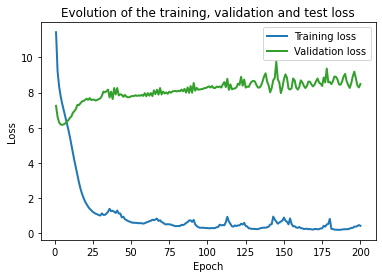

In [34]:
# plot the loss history
plot_loss(BM_reg.train_loss_history, BM_reg.val_loss_history)

In [35]:
# Check the benchmark models
bm_loss, bm_model, loss_history = BM_reg.select_model()

6.162324790159861
./content/model5.pth


In [36]:
# Split conformal prediction 
alpha = 0.1

coverage_BM = []
size_BM = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # pi, cal_scores, test_pred, qhat = C_PI.benchmark_ICP(input, calib_loader, bm_model)
  benchmarkPI = C_PI.benchmark_ICP(input, calib_loader, bm_model)
  size_BM.append(benchmarkPI[0]._measure)
  coverage_BM.append(response in benchmarkPI[0])

print("The marginal coverage rate is (BM) {}".format(sum(coverage_BM)/len(coverage_BM)))
print("The average size is (BM) {}".format(sum(size_BM)/len(size_BM)))

100%|██████████| 100/100 [00:22<00:00,  4.42it/s]

The marginal coverage rate is (BM) 0.9
The average size is (BM) 5.16463374972343


## Conforamlized early stopping

In [39]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

np.random.seed(666)
idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set
idx_train_CES, idx_cal_CES = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]

# load the dataset
X, y = datasets.GetDataset('meps_21', '')

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_CES])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# # scale the labels by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_CES]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_CES, y_train_CES = X_train[idx_train_CES], y_train[idx_train_CES]
X_cal_CES, y_cal_CES = X_train[idx_cal_CES], y_train[idx_cal_CES]

print("Size (CES): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_CES.shape[0], X_train_CES.shape[1], X_cal_CES.shape[0], X_cal_CES.shape[1], 
       X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (CES): train (3000, 139), calibration (1000, 139), test (100, 139)


In [41]:
# set model hyperparameter
input_size = X_train_CES.shape[1]
hidden_layer_size = 64
batch_size = 64
num_epochs = 200
learning_rate = 0.0005
wd = 0.01

num_workers = 0

seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

In [40]:
train_loader = DataLoader(PrepareData(X_train_CES, y_train_CES, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_CES, y_cal_CES, scale_X=False), batch_size=batch_size, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (47), calibration (15), test (100)


In [42]:
# intialize the model
mod = mse_model(in_shape = input_size, hidden_size = hidden_layer_size)
optimizer = torch.optim.Adam(mod.parameters(), lr=learning_rate, weight_decay = wd)
if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

CES_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=learning_rate, val_loader=calib_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [43]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_reg.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 8% 	 train_loss: 6.80  took: 0.01s
Epoch 1 of 200, 17% 	 train_loss: 6.46  took: 0.01s
Epoch 1 of 200, 25% 	 train_loss: 28.34  took: 0.01s
Epoch 1 of 200, 34% 	 train_loss: 13.41  took: 0.01s
Epoch 1 of 200, 42% 	 train_loss: 16.41  took: 0.01s
Epoch 1 of 200, 51% 	 train_loss: 13.88  took: 0.01s
Epoch 1 of 200, 59% 	 train_loss: 4.79  took: 0.01s
Epoch 1 of 200, 68% 	 train_loss: 16.16  took: 0.01s
Epoch 1 of 200, 76% 	 train_loss: 4.67  took: 0.01s
Epoch 1 of 200, 85% 	 train_loss: 9.26  took: 0.01s
Epoch 1 of 200, 93% 	 train_loss: 2.62  took: 0.01s
val_loss = 6.57
Snapshot saved at epoch 1.
Epoch 2 of 200, 8% 	 train_loss: 4.21  took: 0.01s
Epoch 2 of 200, 17% 	 train_loss: 4.72  took: 0.01s
Epoch 2 of 200, 25% 	 train_loss: 22.38  took: 0.01s
Epoch 2 of 200, 34% 	 train_loss: 10.85  took: 0.01s
Epoch 2 of 200, 42% 	 train_loss: 15.23  took: 0.01s
Epoch 2 of 200, 51% 	 train_loss: 10.56  took: 0.01s
Epoch 2 of 200, 59% 	 train_loss: 3.73  took: 0.01s
Epoch 2 of 200

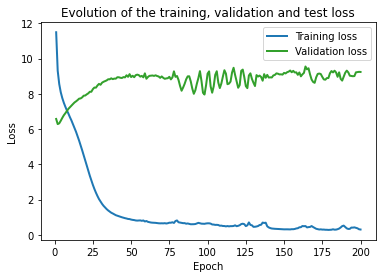

In [44]:
plot_loss(CES_reg.train_loss_history, CES_reg.val_loss_history)

In [45]:
alpha = 0.1

coverage_CES = []
size_CES = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find the best models
  best_models = CES_reg.select_model(input)
  # do ICP using the best models
  CESPI = C_PI.CES_icp(input, calib_loader, best_models, method = 'union')
  # compute the size of the prediction interval
  size_single = sum([intv._measure for intv in CESPI])
  # compute the coverage of the prediction interval
  coverage_single = sum([response in intv for intv in CESPI]) > 0
  size_CES.append(size_single)
  coverage_CES.append(coverage_single)

  1%|          | 1/100 [00:20<33:50, 20.51s/it]

elapse time (selecting best models):20.45652747154236


  2%|▏         | 2/100 [00:39<32:10, 19.70s/it]

elapse time (selecting best models):19.07807683944702


  3%|▎         | 3/100 [00:58<31:13, 19.31s/it]

elapse time (selecting best models):18.783034086227417


  4%|▍         | 4/100 [01:18<31:11, 19.49s/it]

elapse time (selecting best models):19.665865421295166


  5%|▌         | 5/100 [01:37<30:41, 19.39s/it]

elapse time (selecting best models):19.088191747665405


  6%|▌         | 6/100 [01:56<30:10, 19.26s/it]

elapse time (selecting best models):18.930604219436646


  7%|▋         | 7/100 [02:18<31:02, 20.02s/it]

elapse time (selecting best models):21.483546257019043


  8%|▊         | 8/100 [02:37<30:14, 19.73s/it]

elapse time (selecting best models):18.98614192008972


  9%|▉         | 9/100 [02:56<29:31, 19.46s/it]

elapse time (selecting best models):18.795859575271606


 10%|█         | 10/100 [03:15<29:25, 19.61s/it]

elapse time (selecting best models):19.87671422958374


 11%|█         | 11/100 [03:34<28:45, 19.39s/it]

elapse time (selecting best models):18.77637815475464


 12%|█▏        | 12/100 [03:53<28:16, 19.28s/it]

elapse time (selecting best models):18.9837908744812


 13%|█▎        | 13/100 [04:13<28:08, 19.41s/it]

elapse time (selecting best models):19.636672019958496


 14%|█▍        | 14/100 [04:32<27:30, 19.20s/it]

elapse time (selecting best models):18.66480827331543


 15%|█▌        | 15/100 [04:51<27:07, 19.15s/it]

elapse time (selecting best models):18.921323537826538


 16%|█▌        | 16/100 [05:11<27:07, 19.38s/it]

elapse time (selecting best models):19.844520807266235


 17%|█▋        | 17/100 [05:30<26:57, 19.49s/it]

elapse time (selecting best models):19.54345679283142


 18%|█▊        | 18/100 [05:49<26:24, 19.32s/it]

elapse time (selecting best models):18.875386953353882


 19%|█▉        | 19/100 [06:10<26:45, 19.82s/it]

elapse time (selecting best models):20.90893840789795


 20%|██        | 20/100 [06:30<26:22, 19.79s/it]

elapse time (selecting best models):19.658397436141968


 21%|██        | 21/100 [06:51<26:33, 20.17s/it]

elapse time (selecting best models):20.99043345451355


 22%|██▏       | 22/100 [07:11<26:09, 20.12s/it]

elapse time (selecting best models):19.961726188659668


 23%|██▎       | 23/100 [07:30<25:30, 19.87s/it]

elapse time (selecting best models):19.207409143447876


 24%|██▍       | 24/100 [07:50<24:57, 19.70s/it]

elapse time (selecting best models):19.22260618209839


 25%|██▌       | 25/100 [08:10<24:44, 19.79s/it]

elapse time (selecting best models):19.90497660636902


 26%|██▌       | 26/100 [08:29<24:06, 19.55s/it]

elapse time (selecting best models):18.865148305892944


 27%|██▋       | 27/100 [08:49<23:58, 19.70s/it]

elapse time (selecting best models):20.00183629989624


 28%|██▊       | 28/100 [09:09<23:40, 19.73s/it]

elapse time (selecting best models):19.759321928024292


 29%|██▉       | 29/100 [09:28<23:07, 19.55s/it]

elapse time (selecting best models):19.080432653427124


 30%|███       | 30/100 [09:47<22:38, 19.40s/it]

elapse time (selecting best models):18.96179175376892


 31%|███       | 31/100 [10:08<22:45, 19.79s/it]

elapse time (selecting best models):20.645535945892334


 32%|███▏      | 32/100 [10:27<22:16, 19.66s/it]

elapse time (selecting best models):19.31367588043213
elapse time (selecting best models):19.244975805282593


 34%|███▍      | 34/100 [11:06<21:39, 19.69s/it]

elapse time (selecting best models):19.662842988967896


 35%|███▌      | 35/100 [11:26<21:16, 19.63s/it]

elapse time (selecting best models):19.385074615478516


 36%|███▌      | 36/100 [11:45<20:41, 19.40s/it]

elapse time (selecting best models):18.763633728027344


 37%|███▋      | 37/100 [12:07<21:16, 20.26s/it]

elapse time (selecting best models):22.16228413581848


 38%|███▊      | 38/100 [12:26<20:39, 19.99s/it]

elapse time (selecting best models):19.315311193466187


 39%|███▉      | 39/100 [12:45<20:02, 19.72s/it]

elapse time (selecting best models):18.969792127609253


 40%|████      | 40/100 [13:05<19:43, 19.73s/it]

elapse time (selecting best models):19.656862258911133


 41%|████      | 41/100 [13:24<19:09, 19.48s/it]

elapse time (selecting best models):18.796070098876953


 42%|████▏     | 42/100 [13:44<18:57, 19.61s/it]

elapse time (selecting best models):19.821741342544556


 43%|████▎     | 43/100 [14:04<18:42, 19.70s/it]

elapse time (selecting best models):19.76574993133545


 44%|████▍     | 44/100 [14:22<18:05, 19.39s/it]

elapse time (selecting best models):18.60627555847168


 45%|████▌     | 45/100 [14:42<17:45, 19.37s/it]

elapse time (selecting best models):19.25423312187195


 46%|████▌     | 46/100 [15:02<17:38, 19.60s/it]

elapse time (selecting best models):20.041040658950806


 47%|████▋     | 47/100 [15:21<17:12, 19.49s/it]

elapse time (selecting best models):19.138903856277466


 48%|████▊     | 48/100 [15:40<16:42, 19.27s/it]

elapse time (selecting best models):18.72649908065796


 49%|████▉     | 49/100 [16:00<16:29, 19.40s/it]

elapse time (selecting best models):19.613096714019775


 50%|█████     | 50/100 [16:19<16:02, 19.25s/it]

elapse time (selecting best models):18.8324773311615


 51%|█████     | 51/100 [16:38<15:47, 19.34s/it]

elapse time (selecting best models):19.42691469192505


 52%|█████▏    | 52/100 [16:58<15:32, 19.43s/it]

elapse time (selecting best models):19.515581607818604


 53%|█████▎    | 53/100 [17:17<15:11, 19.40s/it]

elapse time (selecting best models):19.26633620262146


 54%|█████▍    | 54/100 [17:38<15:14, 19.89s/it]

elapse time (selecting best models):20.957226276397705


 55%|█████▌    | 55/100 [17:58<14:49, 19.76s/it]

elapse time (selecting best models):19.379949808120728


 56%|█████▌    | 56/100 [18:17<14:25, 19.66s/it]

elapse time (selecting best models):19.397032737731934


 57%|█████▋    | 57/100 [18:37<14:11, 19.81s/it]

elapse time (selecting best models):20.012773513793945


 58%|█████▊    | 58/100 [18:56<13:44, 19.64s/it]

elapse time (selecting best models):19.154505252838135


 59%|█████▉    | 59/100 [19:15<13:17, 19.46s/it]

elapse time (selecting best models):18.94125771522522


 60%|██████    | 60/100 [19:35<13:04, 19.60s/it]

elapse time (selecting best models):19.876402854919434


 61%|██████    | 61/100 [19:54<12:36, 19.39s/it]

elapse time (selecting best models):18.843517541885376


 62%|██████▏   | 62/100 [20:13<12:11, 19.24s/it]

elapse time (selecting best models):18.84871244430542


 63%|██████▎   | 63/100 [20:34<12:05, 19.60s/it]

elapse time (selecting best models):20.3863205909729


 64%|██████▍   | 64/100 [20:53<11:41, 19.50s/it]

elapse time (selecting best models):19.140501737594604


 65%|██████▌   | 65/100 [21:12<11:16, 19.33s/it]

elapse time (selecting best models):18.912384271621704


 66%|██████▌   | 66/100 [21:33<11:13, 19.80s/it]

elapse time (selecting best models):20.776405811309814


 67%|██████▋   | 67/100 [21:52<10:47, 19.63s/it]

elapse time (selecting best models):19.169641494750977


 68%|██████▊   | 68/100 [22:11<10:26, 19.59s/it]

elapse time (selecting best models):19.396188735961914


 69%|██████▉   | 69/100 [22:32<10:12, 19.76s/it]

elapse time (selecting best models):20.085878610610962


 70%|███████   | 70/100 [22:50<09:44, 19.48s/it]

elapse time (selecting best models):18.71258282661438


 71%|███████   | 71/100 [23:09<09:21, 19.37s/it]

elapse time (selecting best models):19.041719913482666


 72%|███████▏  | 72/100 [23:29<09:07, 19.57s/it]

elapse time (selecting best models):19.98284935951233


 73%|███████▎  | 73/100 [23:49<08:43, 19.40s/it]

elapse time (selecting best models):18.91008448600769


 74%|███████▍  | 74/100 [24:07<08:20, 19.25s/it]

elapse time (selecting best models):18.83657717704773


 75%|███████▌  | 75/100 [24:27<08:07, 19.49s/it]

elapse time (selecting best models):19.958038330078125


 76%|███████▌  | 76/100 [24:47<07:45, 19.39s/it]

elapse time (selecting best models):19.11013960838318


 77%|███████▋  | 77/100 [25:07<07:31, 19.61s/it]

elapse time (selecting best models):20.060580492019653


 78%|███████▊  | 78/100 [25:27<07:14, 19.73s/it]

elapse time (selecting best models):19.91929602622986


 79%|███████▉  | 79/100 [25:46<06:52, 19.63s/it]

elapse time (selecting best models):19.36962389945984


 80%|████████  | 80/100 [26:06<06:30, 19.55s/it]

elapse time (selecting best models):19.2539279460907


 81%|████████  | 81/100 [26:25<06:12, 19.60s/it]

elapse time (selecting best models):19.64184808731079


 82%|████████▏ | 82/100 [26:45<05:53, 19.63s/it]

elapse time (selecting best models):19.615350008010864


 83%|████████▎ | 83/100 [27:04<05:32, 19.58s/it]

elapse time (selecting best models):19.449647665023804


 84%|████████▍ | 84/100 [27:24<05:14, 19.69s/it]

elapse time (selecting best models):19.857224941253662


 85%|████████▌ | 85/100 [27:43<04:52, 19.53s/it]

elapse time (selecting best models):19.114949703216553


 86%|████████▌ | 86/100 [28:04<04:38, 19.90s/it]

elapse time (selecting best models):20.637788772583008


 87%|████████▋ | 87/100 [28:24<04:16, 19.72s/it]

elapse time (selecting best models):19.223127126693726


 88%|████████▊ | 88/100 [28:43<03:55, 19.60s/it]

elapse time (selecting best models):19.193288326263428


 89%|████████▉ | 89/100 [29:04<03:39, 19.94s/it]

elapse time (selecting best models):20.611361980438232


 90%|█████████ | 90/100 [29:23<03:16, 19.70s/it]

elapse time (selecting best models):19.000704288482666


 91%|█████████ | 91/100 [29:42<02:56, 19.58s/it]

elapse time (selecting best models):19.202901363372803


 92%|█████████▏| 92/100 [30:02<02:38, 19.84s/it]

elapse time (selecting best models):20.272117853164673


 93%|█████████▎| 93/100 [30:22<02:17, 19.69s/it]

elapse time (selecting best models):19.2801251411438


 94%|█████████▍| 94/100 [30:41<01:57, 19.59s/it]

elapse time (selecting best models):19.25963830947876


 95%|█████████▌| 95/100 [31:01<01:38, 19.73s/it]

elapse time (selecting best models):19.911298036575317


 96%|█████████▌| 96/100 [31:21<01:18, 19.60s/it]

elapse time (selecting best models):19.225967168807983


 97%|█████████▋| 97/100 [31:40<00:58, 19.43s/it]

elapse time (selecting best models):18.9345703125


 98%|█████████▊| 98/100 [32:00<00:39, 19.62s/it]

elapse time (selecting best models):19.981507539749146


 99%|█████████▉| 99/100 [32:19<00:19, 19.41s/it]

elapse time (selecting best models):18.838582038879395


100%|██████████| 100/100 [32:39<00:00, 19.59s/it]

elapse time (selecting best models):20.117040157318115


In [46]:
# on 100 test points
print(sum(coverage_CES)/len(coverage_CES))
print(sum(size_CES)/len(size_CES))

0.89
4.73167987396878
